# **Sistem Rekomendasi Film dan Acara TV Netflix**

## **Sumber Dataset**


https://www.kaggle.com/datasets/shivamb/netflix-shows



*   **Nama:** Maylina Nur'aini
*   **Email:** maylinanuraini@gmail.com
*   **ID Dicoding:** MC444D5X0679



# **Import Library**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# **Data Loading**

Pada Data loading ini, file kaggle.json yang berisi kunci API Kaggle diunggah untuk melakukan autentikasi. Kunci ini kemudian dipindahkan ke direktori khusus agar sistem dapat mengenali dan mengizinkan akses ke Kaggle melalui API. Setelah proses autentikasi berhasil, dataset bernama Netflix Movies and TV Shows diunduh menggunakan perintah API Kaggle. File dataset yang biasanya berupa arsip ZIP kemudian diekstrak untuk mendapatkan file CSV yang berisi data. Selanjutnya, file CSV tersebut dibaca menggunakan pustaka pandas ke dalam sebuah DataFrame. Untuk mendapatkan gambaran awal mengenai isi dataset, lima baris pertama dari DataFrame tersebut ditampilkan menggunakan fungsi df.head(). Langkah ini memudahkan dalam memahami struktur dan tipe data sebelum melanjutkan ke proses analisis lebih lanjut.



In [2]:
# Upload fie json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maylina","key":"b5f64cad00fd18b3dba21521742aea88"}'}

In [3]:
# Setup API Key Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Netflix Shows dari Kaggle
!kaggle datasets download -d shivamb/netflix-shows

# Unzip file dataset
!unzip netflix-shows.zip

Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows
License(s): CC0-1.0
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 587MB/s]
Archive:  netflix-shows.zip
  inflating: netflix_titles.csv      


In [4]:
# Membaca file csv
df = pd.read_csv("netflix_titles.csv")

# Menampilkan 5 baris pertama
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# **Data Understanding**

Pada tahap Data Understanding ini melakukan beberapa langkah penting untuk memahami karakteristik dataset. Dimulai dengan mengecek informasi umum menggunakan `df.info()` untuk melihat tipe data dan jumlah nilai non-null pada setiap kolom. Kemudian, `df.describe()` digunakan untuk mendapatkan statistik deskriptif dari kolom numerik, memberikan gambaran tentang sebaran data seperti nilai rata-rata, standar deviasi, nilai minimum, dan maksimum.

Ukuran dataset dilihat menggunakan `df.shape`, yang menampilkan jumlah baris dan kolom. Untuk mendeteksi adanya nilai yang hilang (missing values), menggunakan `df.isna().sum()`. Selanjutnya, `df.duplicated().sum()` digunakan untuk memeriksa dan menghitung jumlah data duplikat yang ada dalam dataset.

Semua langkah ini penting untuk menilai kualitas data dan mendapatkan wawasan awal sebelum melanjutkan ke tahap analisis dan persiapan data.

In [5]:
# Menampilkan informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


**Insight:**
* Terdapat 11 kolom dengan tipe `object`, yaitu `show_id`, `type`, `title`, `director`, `cast`, `country`, `date_added`, `rating`, `duration`, `listed_in` dan `description`.
* Terdapat 1 kolom numerik dengan tipe int64, yaitu `release_year`.


In [6]:
# Menampilkan statistik deskriptif kolom numerik
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


**Insight:**

* Statistik deskriptif `df.describe()` pada kolom numerik (`release_year`) menunjukkan sebaran tahun rilis konten, mencakup jumlah data (`count`), rata-rata (`mean`), standar deviasi (`std`), serta tahun rilis terlama (`min`) hingga terbaru (`max`) beserta kuartilnya.

In [7]:
# Menampilkan jumlah baris dan kolom dalam bentuk tuple
df.shape

(8807, 12)


**Insight:**

* Dataset ini memiliki 8807 data dan memiliki 12 kolom. Kolom Kategori 11 dan kolom numerik 1.

In [8]:
# Menampilkan missing values
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2634
cast,825
country,831
date_added,10
release_year,0
rating,4
duration,3


**Insight:**

* Hasil dari `df.isna().sum()` menunjukkan jumlah nilai yang hilang (missing values) pada setiap kolom. Kolom `director`, `cast`, `country`, `date_added`, dan `rating` memiliki missing values, sementara kolom lainnya (`show_id`, `type`, `title`, `release_year`, `duration`, `listed_in`, `description`) tidak memiliki missing values. Keberadaan missing values pada kolom-kolom tersebut perlu ditangani pada tahap Data Preparation.

In [9]:
# Menampilkan data duplikat
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


**Insight:**
* Tidak terdapat data duplikat dalam dataset.

In [10]:
# Menampilkan jumlah judul, negara, dan jenis konten yang berbeda
print('Jumlah judul yang berbeda: ', len(df['title'].unique()))
print('Jumlah Negara yang berbeda: ', len(df['country'].dropna().unique()))
print('Jumlah jenis konten yang berbeda: ', len(df['type'].unique()))

Jumlah judul yang berbeda:  8807
Jumlah Negara yang berbeda:  748
Jumlah jenis konten yang berbeda:  2


**Insight:**

*   Terdapat sejumlah besar **judul** yang berbeda, menandakan keragaman konten film dan acara TV.
*   Ada banyak **negara** asal yang berbeda, mencerminkan jangkauan global produksi konten di Netflix.
*   Hanya ada sedikit **jenis konten** yang berbeda (seperti "Movie" dan "TV Show"), yang merupakan kategori utama konten di platform.

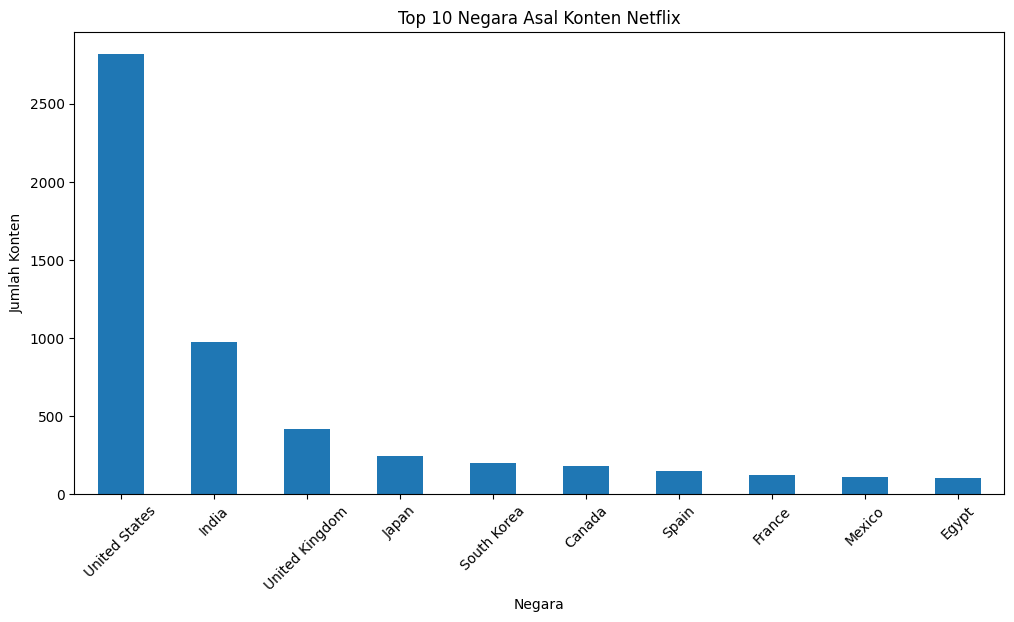

In [11]:
# Distribusi negara (country) 10 teratas
plt.figure(figsize=(12,6))
df['country'].value_counts().dropna().head(10).plot(kind='bar')
plt.title('Top 10 Negara Asal Konten Netflix')
plt.xlabel('Negara')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation=45)
plt.show()

**Insight:**

* Negara United States mendominasi jumlah konten di Netflix, menunjukkan bahwa produksi konten dari Amerika Serikat memiliki pangsa pasar yang besar di platform ini.
* India dan United Kingdom juga memiliki kontribusi konten yang signifikan, menempati posisi kedua dan ketiga, menandakan pentingnya pasar dan produksi dari negara-negara ini.
* Terdapat beragam negara lain dalam 10 besar, yang mencerminkan upaya Netflix untuk menyediakan konten dari berbagai belahan dunia dan menjangkau audiens global.

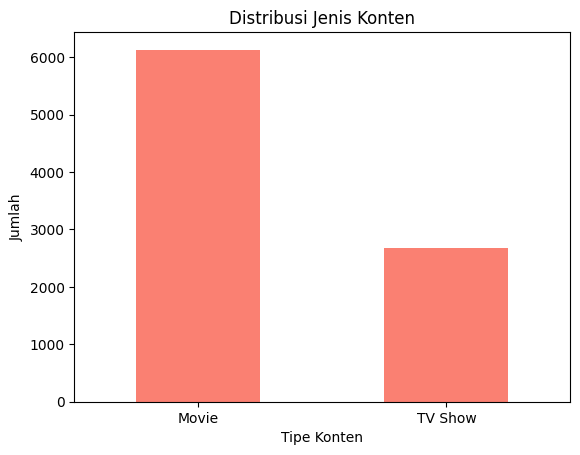

In [12]:
# Distribusi jenis konten (type) 10 teratas
df['type'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribusi Jenis Konten')
plt.xlabel('Tipe Konten')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

**Insight:**
* Jenis konten Movies (Film) memiliki jumlah yang jauh lebih banyak dibandingkan TV Shows (Acara TV) di Netflix.

Hal ini menunjukkan bahwa mayoritas konten yang tersedia di platform Netflix adalah dalam format film.

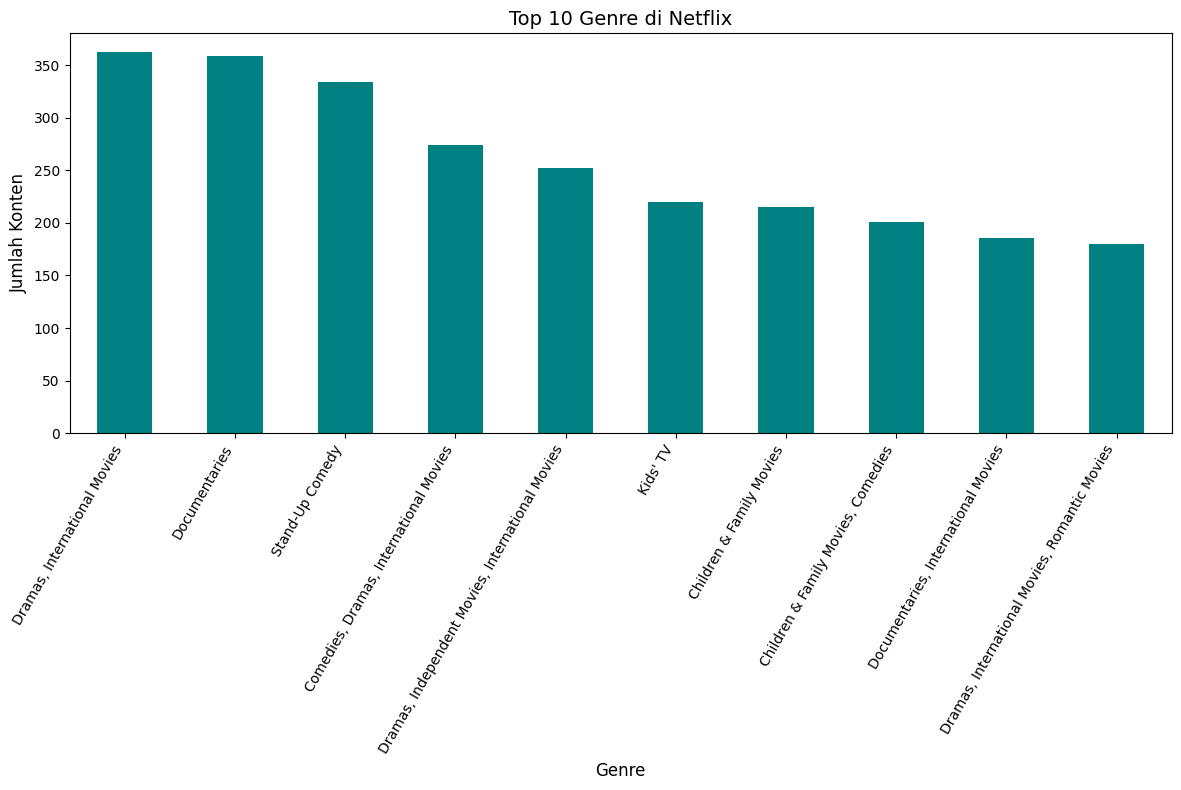

In [13]:
# Distribusi listed_in (genre) 10 teratas
plt.figure(figsize=(12, 8))
df['listed_in'].value_counts().head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Genre di Netflix', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Jumlah Konten', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

**Insight:**
* Grafik ini menunjukkan 10 kombinasi genre yang paling sering muncul pada konten di Netflix.
* Kombinasi genre seperti `Dramas, International Movies` dan `Documentaries` tampak sangat populer.

Ini memberikan gambaran tentang jenis-jenis konten berdasarkan kategori yang paling banyak tersedia di platform tersebut.

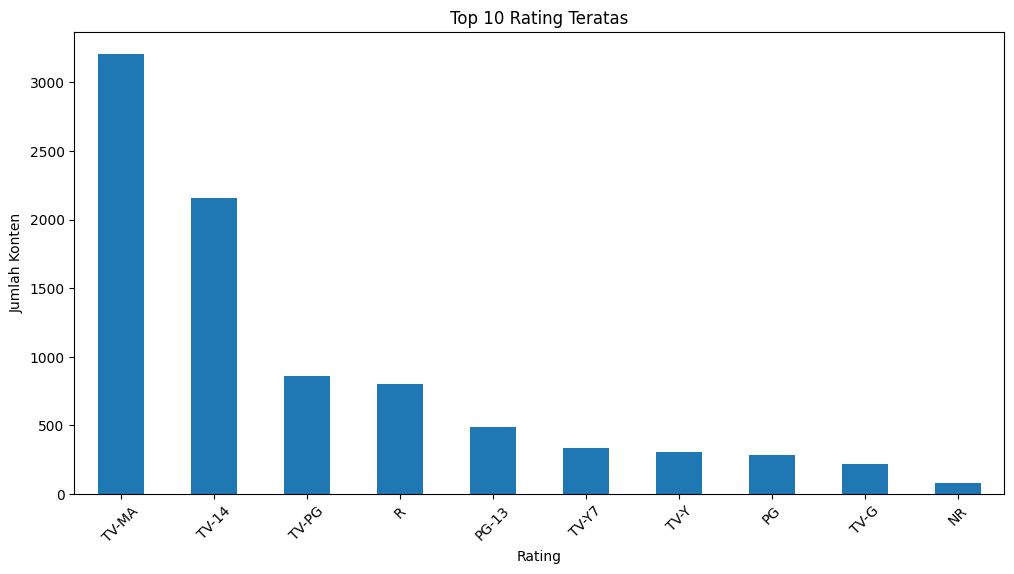

In [14]:
# Visualisasi distribusi 10 rating teratas
plt.figure(figsize=(12,6))
df['rating'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Rating Teratas')
plt.xlabel('Rating')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation=45)
plt.show()

**Insight:**
* Visualisasi ini menampilkan 10 rating yang paling sering ditemukan pada konten di Netflix. Rating seperti TV-MA, TV-14, dan TV-PG muncul sebagai rating dengan jumlah konten terbanyak.

Ini mengindikasikan bahwa sebagian besar konten di Netflix memiliki rating yang umum digunakan untuk menunjukkan kesesuaian usia penonton.

# **Data Preparation**

Pada bagian Data Preparation ini, melakukan pemberihan data dengan menghapus semua baris yang ada nilai kosong (NaN) menggunakan `df.dropna()`. Dan setelah itu dilakukan dengan pengecekan ulang meggunakan `df.isna().sum() unutk memastikan tidak ada lagi missing value nya dalam dataset.

In [15]:
# Menghapus semua baris yang memiliki nilai NaN
df = df.dropna()
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
...,...,...,...,...,...,...,...,...,...,...,...,...
8801,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [16]:
# Mengecek kembali missing value
df.isna().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
date_added,0
release_year,0
rating,0
duration,0


**Insight:**
* Hasilnya menunjukkan bahwa seluruh nilai kosong telah dihilangkan, dan dataset ini hanya berisi baris dengan data lengkap.

# **TF-IDF Vectorizer**

TF-IDF Vectorizer diaplikasikan pada kolom (genre) `listed_in` untuk mengubah informasi kategori film menjadi bentuk numerik yang dapat diproses secara matematis. Dengan menghitung bobot kepentingan tiap kata dalam genre melalui TF-IDF, setiap film diwakili oleh sebuah vektor yang mencerminkan karakteristik genre uniknya. Vektor-vektor ini kemudian disusun dalam bentuk DataFrame dengan baris sebagai judul film dan kolom sebagai fitur genre, memudahkan perhitungan kesamaan antar film untuk keperluan rekomendasi berbasis konten.

In [17]:
data = df
data.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3266,s3267,Movie,GO! The Unforgettable Party,Mauro Scandolari,"Pilar Pascual, José Gimenez Zapiola, Renata To...",Argentina,"November 15, 2019",2019,TV-PG,60 min,"Children & Family Movies, Music & Musicals",Mía's vacation with her dad is disrupted by th...
7961,s7962,Movie,Scream 2,Wes Craven,"Neve Campbell, David Arquette, Courteney Cox, ...",United States,"October 1, 2019",1997,R,121 min,Horror Movies,Gale has written a best-seller which has been ...
1069,s1070,Movie,Uppena,Buchi Babu Sana,"Panja Vaisshnav Tej, Krithi Shetty, Vijay Seth...",India,"April 14, 2021",2020,TV-14,145 min,"Dramas, International Movies, Romantic Movies",The son of a fishing community falls for a vil...
5924,s5925,Movie,Chelsea Peretti: One of the Greats,Lance Bangs,Chelsea Peretti,United States,"November 14, 2014",2014,TV-MA,75 min,Stand-Up Comedy,"""Brooklyn Nine-Nine"" star Chelsea Peretti show..."
1520,s1521,TV Show,Paava Kadhaigal,"Sudha Kongara, Vignesh Shivan, Gautham Vasudev...","Kalidas Jayaram, Shanthnu Bhagyaraj, Bhavani S...",India,"December 18, 2020",2020,TV-MA,1 Season,"International TV Shows, TV Dramas","At times dark, at times disturbing, four short..."


**Insight:**
* Variabel data ini berisi DataFrame yang sudah bersih dari nilai yang hilang, siap untuk diproses lebih lanjut.
* data.sample(5) menampilkan cuplikan data yang sudah bersih.

In [18]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data listed_in
tf.fit(data['listed_in'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'anime', 'british', 'children', 'classic',
       'comedies', 'comedy', 'crime', 'cult', 'documentaries',
       'docuseries', 'dramas', 'faith', 'family', 'fantasy', 'features',
       'fi', 'horror', 'independent', 'international', 'kids', 'korean',
       'language', 'lgbtq', 'movies', 'music', 'musicals', 'mysteries',
       'nature', 'reality', 'romantic', 'sci', 'science', 'series',
       'shows', 'spanish', 'spirituality', 'sports', 'stand', 'talk',
       'teen', 'thrillers', 'tv', 'up'], dtype=object)

**Insight:**

* Array ini menampilkan daftar semua genre unik yang ada dalam kolom `listed_in` setelah diekstraksi oleh `TfidfVectorizer`.
* Daftar ini merepresentasikan fitur-fitur yang akan digunakan untuk membangun matriks TF-IDF, di mana setiap film akan diwakili oleh seberapa sering dan seberapa penting masing-masing genre ini muncul di dalamnya.

In [19]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['listed_in'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(5332, 45)

**Insight:**

* Matriks TF-IDF yang dihasilkan memiliki ukuran (5332, 45). Terdapat 5332 baris (sesuai dengan jumlah film dalam data setelah proses pembersihan) dan 45 kolom (sesuai dengan jumlah genre unik yang teridentifikasi).
* Setiap baris merepresentasikan sebuah film, dan setiap kolom merepresentasikan bobot TF-IDF dari sebuah genre untuk film tersebut.

Ukuran matriks ini menunjukkan bahwa proses transformasi teks genre menjadi representasi numerik berhasil dilakukan, dan matriks ini siap digunakan untuk menghitung kesamaan antar film.

In [20]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.62655199,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

**Insight:**
* Matriks numerik yang menampilkan bobot TF-IDF untuk setiap genre (kolom) untuk setiap film (baris). Matriks ini dalam format dense, artinya semua nilai, termasuk nol, akan ditampilkan.

In [21]:
# Membuat DataFrame TF-IDF dengan dengan baris berupa nama produk dan kolom berupa jenis kategori

df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data['title']
)

# Menampilkan sampel 22 kolom dan 22 baris secara acak
df_tfidf.sample(22, axis=1).sample(22, axis=1)

,thrillers,action,music,tv,language,faith,children,fantasy,family,sci,...,teen,movies,docuseries,crime,comedies,horror,lgbtq,kids,talk,romantic
title,,,,,,,,,,,,,,,,,,,,,
Sankofa,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.559273,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
The Great British Baking Show,0.000000,0.0,0.000000,0.626552,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
The Starling,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.772283,0.000000,0.0,0.0,0.0,0.000000
Je Suis Karl,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.460660,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Jeans,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.526351,0.0,0.0,0.441448,0.000000,0.0,0.0,0.0,0.634682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinzana,0.752119,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.303587,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Zodiac,0.494378,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.199552,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Zombieland,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.290530,0.0,0.0,0.487333,0.823468,0.0,0.0,0.0,0.000000


**Insight:**

* Hasil ini menunjukkan representasi numerik dari setiap judul film (baris) berdasarkan bobot TF-IDF dari berbagai genre (kolom).
* Di setiap nilai dalam tabel mencerminkan seberapa penting sebuah genre bagi film tersebut. Nilai yang lebih tinggi menunjukkan relevansi genre yang lebih besar.

# **Modeling**

## **Cosine Similarity**

Cosine similarity diterapkan untuk menilai sejauh mana dua film memiliki kemiripan genre, dengan memanfaatkan representasi vektor TF-IDF dan DataFrame sebagai alat visualisasi tingkat kemiripan tersebut.

In [22]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.24512115, ..., 0.16248587, 0.13658052,
        0.33912223],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24512115, 0.        , 1.        , ..., 0.37635857, 0.31635521,
        0.18609405],
       ...,
       [0.16248587, 0.        , 0.37635857, ..., 1.        , 0.27057992,
        0.061679  ],
       [0.13658052, 0.        , 0.31635521, ..., 0.27057992, 1.        ,
        0.05184543],
       [0.33912223, 0.        , 0.18609405, ..., 0.061679  , 0.05184543,
        1.        ]])

* Nilai pada diagonal matriks (dari kiri atas ke kanan bawah) adalah `1.0`, menunjukkan bahwa setiap film memiliki kemiripan sempurna dengan dirinya sendiri, seperti yang diharapkan.
* Nilai di luar diagonal menunjukkan seberapa mirip satu film dengan film lainnya. Nilai yang mendekati 1 menunjukkan kemiripan genre yang tinggi, sementara nilai yang mendekati 0 menunjukkan sedikit atau tidak ada kesamaan genre.

Matriks cosine_sim ini adalah inti dari sistem rekomendasi berbasis konten, karena menyediakan ukuran kuantitatif dari kesamaan antara setiap pasang film, memungkinkan untuk mengidentifikasi film-film serupa berdasarkan genre.

In [23]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada beberapa judul film secara acak
cosine_sim_df.sample(20, axis=1).sample(20, axis=0)

Shape: (5332, 5332)


title,Hide and Seek,The Witch: Part 1 - The Subversion,Panipat - The Great Betrayal,Airplane Mode,Dorasaani,Loving You,First Impression,Thomas and Friends,The Sapphires,The Golem,The First Line,The Do-Over,W. Kamau Bell: Private School Negro,Greg Davies: You Magnificent Beast,The Lord of the Rings: The Return of the King,The Boss Baby: Get That Baby!,One Like It,Sylvia,Eli,Bruno and Boots: The Wizzle War
title,,,,,,,,,,,,,,,,,,,,
Rise of the Zombie,0.342241,0.159509,0.424462,0.410872,0.424462,0.471553,0.173231,0.000000,0.163625,0.870661,0.190298,0.000000,0.0,0.0,0.000000,0.131279,0.436572,0.310766,0.897275,0.131279
The Social Dilemma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tarif de nuit,1.000000,0.146314,0.346186,0.335102,0.346186,0.432545,0.107740,0.000000,0.101766,0.328720,0.118355,0.000000,0.0,0.0,0.000000,0.081648,0.356062,0.908034,0.111237,0.081648
Anarkali of Aarah,0.356062,0.165951,0.586354,0.427466,0.586354,0.735852,0.180227,0.000000,0.764330,0.736708,0.888924,0.000000,0.0,0.0,0.000000,0.136581,1.000000,0.484947,0.186077,0.136581
Bilu Rakkhosh,0.432545,0.201598,0.715442,0.461717,0.715442,1.000000,0.148449,0.000000,0.407176,0.452924,0.473550,0.000000,0.0,0.0,0.000000,0.112498,0.735852,0.659027,0.153267,0.112498
Buffalo Boys,0.267945,0.546061,0.295476,0.286016,0.295476,0.369185,0.091958,0.000000,0.086859,0.280569,0.101018,0.771142,0.0,0.0,0.436318,0.069688,0.303906,0.243303,0.094943,0.069688
Cut Bank,0.723629,0.000000,0.182537,0.000000,0.182537,0.309281,0.000000,0.000000,0.204359,0.000000,0.237671,0.000000,0.0,0.0,0.000000,0.000000,0.187744,0.860905,0.000000,0.000000
Indoo Ki Jawani,0.241685,0.492543,0.266518,0.448579,0.266518,0.333003,0.316324,0.000000,0.298784,0.253071,0.091117,0.902183,0.0,0.0,0.393556,0.239719,0.274121,0.219458,0.085638,0.239719
Miracle,0.120852,0.056326,0.290108,0.190261,0.290108,0.325029,0.116485,0.000000,0.214764,0.221734,0.249773,0.000000,0.0,0.0,0.000000,0.660031,0.298385,0.214203,0.120266,0.660031


**Insight:**
* Baris dan kolom berupa judul film.
* Setiap nilai dalam sel matriks menunjukkan skor cosine similarity antara film pada baris dan film pada kolom tersebut.

## **Mendapatkan Rekomendasi**

Fungsi ```product_recommendations``` menghasilkan daftar produk yang paling mirip dengan produk yang dipilih, menggunakan nilai ```cosine similarity``` untuk mengurutkan rekomendasi berdasarkan tingkat kesamaan kategori. Fungsi ini juga menyajikan detail kategori agar pengguna dapat memahami alasan kemiripan tersebut.

In [24]:
print(data.columns)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [25]:
items = data[['title', 'listed_in']]

**Insight:**

* Kode `items = data[['title', 'listed_in']]` membuat DataFrame baru bernama items yang hanya berisi kolom judul (title) dan genre (listed_in) dari data yang sudah dibersihkan. Pemilihan kolom ini bertujuan untuk mempermudah akses informasi yang relevan untuk proses rekomendasi berbasis genre di langkah selanjutnya.

In [26]:
def product_recommendations(nama_show, similarity_data=cosine_sim_df, items=data[['title', 'listed_in']], k=10):
    # Cek apakah nama show ada di kolom similarity
    if nama_show not in similarity_data.columns:
        raise ValueError(f"Show '{nama_show}' tidak ditemukan di data similarity.")

    # Mengambil indeks top-k similarity tertinggi
    index = similarity_data.loc[:, nama_show].to_numpy().argpartition(-k-1)[-k-1:]

    # Urutkan berdasarkan similarity tertinggi
    sorted_index = index[similarity_data.loc[:, nama_show].to_numpy()[index].argsort()[::-1]]

    # Ambil nama-nama show terdekat
    closest = similarity_data.columns[sorted_index]

    # Hapus show yang sama dari hasil rekomendasi
    closest = closest.drop(nama_show, errors='ignore')

    # Gabungkan dengan genre
    return pd.DataFrame(closest, columns=['title']).merge(items, on='title').head(k)

**Insight:**
* Fungsi `product_recommendations` mengambil nama acara/film dan menggunakan skor `cosine similarity` untuk mengembalikan daftar `k ` rekomendasi teratas berdasarkan kemiripan genre, memastikan bahwa acara/film input ada dalam data dan rekomendasi yang diberikan memiliki detail genre.

In [27]:
# Menampilkan informasi title dengan nama 'Holiday Rush'
data[data.title.eq('Holiday Rush')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3218,s3219,Movie,Holiday Rush,Leslie Small,"Romany Malco, Sonequa Martin-Green, Darlene Lo...",United States,"November 28, 2019",2019,TV-PG,94 min,"Children & Family Movies, Dramas",A widowed radio DJ and his four spoiled kids n...


**Insight:**
* Verifikasi keberadaan film `Holiday Rush` dan identifikasinya sebagai titik awal rekomendasi berdasarkan genrenya (`Children & Family Movies, Dramas`).

In [30]:
# Mendapatkan rekomendasi title yang mirip dengan Holiday Rush
product_recommendations('Holiday Rush')

,title,listed_in
0,Wish Man,"Children & Family Movies, Dramas"
1,Big Miracle,"Children & Family Movies, Dramas"
2,A Champion Heart,"Children & Family Movies, Dramas"
3,White Fang,"Children & Family Movies, Dramas"
4,You Are My Home,"Children & Family Movies, Dramas"
5,Hachi: A Dog's Tale,"Children & Family Movies, Dramas"
6,Balto,"Children & Family Movies, Dramas"
7,The Karate Kid Part III,"Children & Family Movies, Dramas"
8,The Indian in the Cupboard,"Children & Family Movies, Dramas"
9,Hugo,"Children & Family Movies, Dramas"


**Insight:**

* Sistem rekomendasi berhasil menemukan film/acara TV lain dengan genre yang serupa, yang membuktikan efektivitas model dalam merekomendasikan konten berbasis kemiripan genre. Rekomendasi ini mencakup judul-judul seperti yang ditampilkan pada hasil eksekusi fungsi product_recommendations, di mana setiap rekomendasi memiliki korelasi genre yang relevan dengan film awal ('Holiday Rush'), khususnya pada genre Children & Family Movies dan Dramas.

### **Metode evaluasi: Precision@k**

Metode evaluasi Precision@k adalah cara untuk mengukur seberapa banyak item relevan yang ada dalam k rekomendasi teratas yang diberikan oleh sistem rekomendasi. Ini membantu menilai keakuratan rekomendasi di posisi awal.

In [35]:
# Definisikan fungsi precision_at_k
def precision_at_k(nama_show, k=10, similarity_threshold=0.5, similarity_data=cosine_sim_df):
    """
    Menghitung Precision@k untuk rekomendasi berdasarkan kemiripan kosinus.

    Args:
        nama_show (str): Nama show yang akan dievaluasi rekomendasinya.
        k (int): Jumlah rekomendasi teratas yang akan dipertimbangkan.
        similarity_threshold (float): Ambang batas kemiripan kosinus untuk dianggap relevan.
        similarity_data (pd.DataFrame): DataFrame kemiripan kosinus.

    Returns:
        float: Nilai Precision@k.
    """
    if nama_show not in similarity_data.columns:
        print(f"Show '{nama_show}' tidak ditemukan di data similarity.")
        return 0.0

    # Ambil skor kemiripan untuk show yang diberikan, urutkan menurun, dan ambil top k+1 (termasuk show itu sendiri)
    sim_scores = similarity_data.loc[:, nama_show].sort_values(ascending=False)

    # Hilangkan show itu sendiri dari skor
    sim_scores = sim_scores.drop(nama_show, errors='ignore')

    # Ambil top-k rekomendasi
    top_k_recommendations = sim_scores.head(k)

    # Hitung jumlah item relevan dalam top-k
    # Relevan jika skor kemiripan di atas threshold
    relevant_count = (top_k_recommendations > similarity_threshold).sum()

    # Hitung Precision@k
    precision = relevant_count / k if k > 0 else 0.0

    return precision

# Hitung Precision@10 untuk 'Holiday Rush' dengan threshold kemiripan 0.5
precision_10 = precision_at_k('Holiday Rush', k=10, similarity_threshold=0.5)
print(f"Precision@10 untuk 'Holiday Rush': {precision_10}")

Precision@10 untuk 'Holiday Rush': 1.0


**Insight:**
* Fungsi precision_at_k digunakan untuk mengevaluasi akurasi rekomendasi.
* Precision@10 sebesar 1.0 untuk `Holiday Rush` dengan threshold 0.5 menunjukkan bahwa semua 10 rekomendasi teratas sangat relevan.